<a href="https://colab.research.google.com/github/gautam1998/bit-predict/blob/main/notebooks/01_bit_price_predict_consolidated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***Build a model to predict Bitcoin prices***

This notebook is adapted from the Milestone Project 3 of the [tensorflow course offered by ZTM](https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/)

Check if the GPU is being utilized

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a9762950-8fcd-4cfa-4c4e-bd6f62c0fa17)


Link Drive to Colab

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
#!cd '/content/gdrive/MyDrive'
#!mkdir 'BitPredict'
!cd '/content/gdrive/MyDrive/BitPredict'

##Data Preperation

Download the data from the mrdbourke/tensorflow-deep-learning repository



In [ ]:
!wget -P data/ https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-07-02 12:26:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘data/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2022-07-02 12:26:15 (7.03 MB/s) - ‘data/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



Load the dataset in a dataframe indexed on the date

In [ ]:
import pandas as pd

df = pd.read_csv("/content/gdrive/MyDrive/BitPredict/data/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",parse_dates=["Date"],index_col=["Date"])
df.head(5)

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [ ]:
bitcoin_prices = df[["Closing Price (USD)"]].rename(columns = {"Closing Price (USD)":"prices"})
bitcoin_prices.head()

,prices
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


Plot the price of bitcoin over time

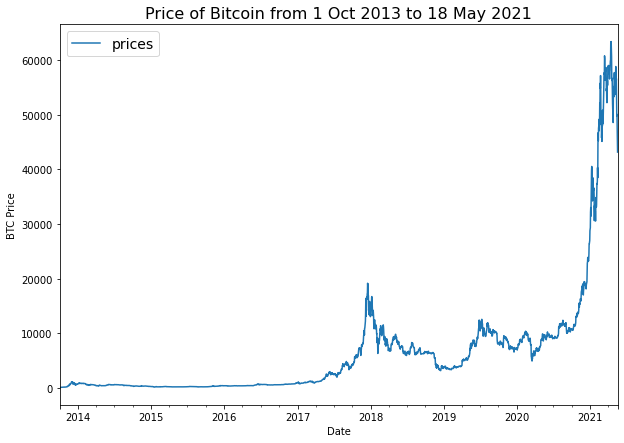

In [ ]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

**Insight**, our data is not stationary

In [ ]:
timestamps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices.prices.to_numpy()

Set the split size to **0.8**

In [ ]:
#Split into train and test sets for naive data

split_size = 0.8
train_size = int(split_size*(len(bitcoin_prices)))

X_train,y_train = timestamps[:train_size],prices[:train_size]
X_test,y_test = timestamps[train_size:],prices[train_size:]

len(X_train),len(y_train),len(X_test),len(y_test)

(2229, 2229, 558, 558)

The test data can be assumed to be the data in the future , we learn patterns from the historical data and make predictions for the future.

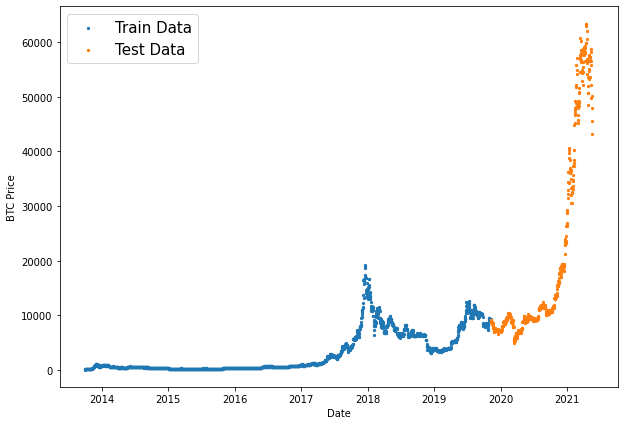

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(X_train,y_train,s=5,label='Train Data')
plt.scatter(X_test,y_test,s=5,label='Test Data')
plt.legend(fontsize=15)
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.show();

In [ ]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

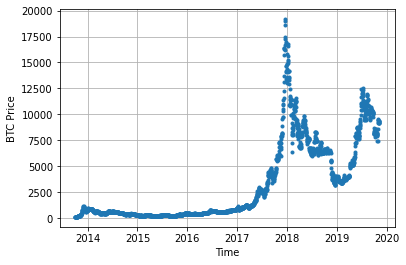

In [ ]:
plot_time_series(X_train,y_train)

##Modelling Experiements

Various models we will experiment with

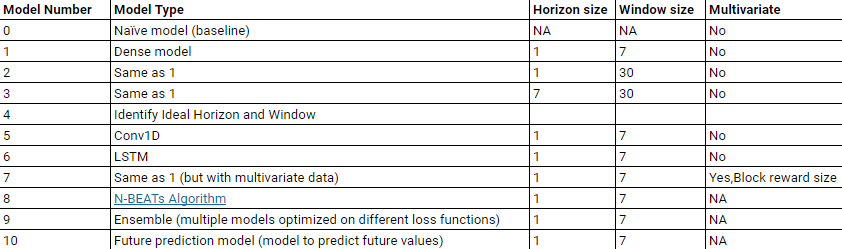

Aditionally we will also be creating a statistical model using ARIMA and a model using Neural Prophet

**Some additional modelling experiments we can explore**

Moving average	https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/

ARIMA (Autoregression Integrated Moving Average)	https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

sktime (Scikit-Learn for time series)	https://github.com/alan-turing-institute/sktime

TensorFlow Decision Forests (random forest, gradient boosting trees)	https://www.tensorflow.org/decision_forests

Facebook Kats (purpose-built forecasting and time series analysis library by Facebook)	https://github.com/facebookresearch/Kats

LinkedIn Greykite (flexible, intuitive and fast forecasts)	https://github.com/linkedin/greykite

###Evaluation Metrics

This function evaluates a models predictions 

We will be using multiple time series metrics



1.   mae
2.   mse
3.   rmse
4.   mape
5.   mase


In [ ]:
import tensorflow as tf
def mean_absolute_scaled_error(y_true,y_pred):

  mae = tf.reduce_mean(tf.abs(y_pred - y_true))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return (mae/mae_naive_no_season)

def evaluate_preds(y_true,y_pred):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)
  
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) 
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

###*Naive Model*

The naive model simply uses the previous timestep to predict the next timestep



In [ ]:
naive_forecast = y_test[:-1]

y_test[-10:],naive_forecast[-10:]

(array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
        52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
        45604.61575361, 43144.47129086]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

In [ ]:
len(y_train)

2229

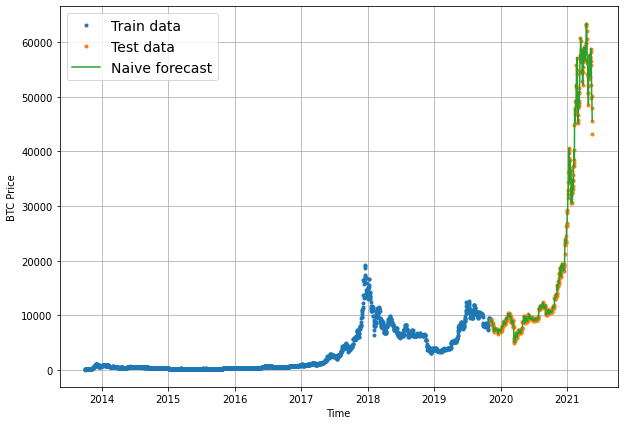

In [ ]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test,label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-",label="Naive forecast");

Our Baseline scores 

The baseline model will be difficult to beat in an open system

In [ ]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

{'mae': 567.9802,
 'mape': 2.5165248,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

###Windowing the data set

Window is the number of days in the past we are looking into to predict the future ie the horizon

eg window 7 and forecast 1
```
[1,2,3,4,5,6,7] -> [8]
```

In [ ]:
#lets first set window and horizon to 7 and 1

import tensorflow as tf

WINDOW = 7
HORIZON = 1

def get_labelled_window(data,HORIZON):

  return data[:,:-HORIZON],data[:,-HORIZON:]

get_labelled_window(tf.expand_dims((tf.range(8)+1),axis=0),1)

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[8]], dtype=int32)>)

In [ ]:
tf.expand_dims(tf.range(WINDOW+HORIZON),axis=0).numpy()


array([[0, 1, 2, 3, 4, 5, 6, 7]], dtype=int32)

In [ ]:
import numpy as np

def make_windows(dataset,HORIZON=1,WINDOW=7):

  window_step = tf.expand_dims(tf.range(WINDOW+HORIZON),axis=0).numpy()

  window_indices = window_step + np.expand_dims(np.arange(len(dataset) - (WINDOW+HORIZON-1)),axis=0).T

  windowed_data = dataset[window_indices]

  windows,labels = get_labelled_window(windowed_data,HORIZON)

  return windows,labels

In [ ]:
full_windows,full_labels = make_windows(prices,1,7)
full_windows,full_labels

(array([[  123.65499   ,   125.455     ,   108.58483   , ...,
           121.33866   ,   120.65533   ,   121.795     ],
        [  125.455     ,   108.58483   ,   118.67466   , ...,
           120.65533   ,   121.795     ,   123.033     ],
        [  108.58483   ,   118.67466   ,   121.33866   , ...,
           121.795     ,   123.033     ,   124.049     ],
        ...,
        [58788.20967893, 58102.19142623, 55715.54665129, ...,
         52147.82118698, 49764.1320816 , 50032.69313676],
        [58102.19142623, 55715.54665129, 56573.5554719 , ...,
         49764.1320816 , 50032.69313676, 47885.62525472],
        [55715.54665129, 56573.5554719 , 52147.82118698, ...,
         50032.69313676, 47885.62525472, 45604.61575361]]),
 array([[  123.033     ],
        [  124.049     ],
        [  125.96116   ],
        ...,
        [47885.62525472],
        [45604.61575361],
        [43144.47129086]]))

In [ ]:
for i in range(3):
  print(full_windows[i],full_labels[i])

[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] [123.033]
[125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] [124.049]
[108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] [125.96116]


In [ ]:
def split_into_train_and_test(windows,labels,split_size=0.2):

  train_size = int((1-split_size)*(len(windows)))

  train_windows = windows[:train_size]
  train_labels = labels[:train_size]

  test_windows = windows[train_size:]
  test_labels = labels[train_size:]

  return train_windows,train_labels,test_windows,test_labels

In [ ]:
train_windows,train_labels,test_windows,test_labels = split_into_train_and_test(full_windows,full_labels)
len(train_windows),len(train_labels),len(test_windows),len(test_labels)

(2224, 2224, 556, 556)

Creating a callback function to save our best model

In [ ]:
import os

def SaveBestWeights(save_path, model_name):

  filepath = os.path.join(save_path, model_name)

  checkpoint = tf.keras.callbacks.ModelCheckpoint(
      filepath = filepath,
      verbose = 0,
      monitor = 'val_loss',
      save_best_only = True,
      save_freq = 'epoch'
  )

  return checkpoint

###*Dense Model*

Our first dense model 

We will be using a Horizon of 1 and Window of 7

In [ ]:
tf.random.set_seed(42)

input_layer = tf.keras.layers.Input(shape=(7,))
dense_layer = tf.keras.layers.Dense(128,activation='relu')(input_layer)
output_layer = tf.keras.layers.Dense(HORIZON,activation='linear')(dense_layer)

model_1 = tf.keras.Model(input_layer,output_layer)

model_1.compile(
  loss = "mae",
  optimizer = tf.keras.optimizers.Adam(),
  metrics = ["mae"]   
)

model_1_history = model_1.fit(train_windows,train_labels,epochs=100,verbose = 0,validation_data=(test_windows,test_labels),callbacks=[SaveBestWeights("checkpoints","model_1")])

INFO:tensorflow:Assets written to: checkpoints/model_1/assets
INFO:tensorflow:Assets written to: checkpoints/model_1/assets
INFO:tensorflow:Assets written to: checkpoints/model_1/assets
INFO:tensorflow:Assets written to: checkpoints/model_1/assets
INFO:tensorflow:Assets written to: checkpoints/model_1/assets
INFO:tensorflow:Assets written to: checkpoints/model_1/assets
INFO:tensorflow:Assets written to: checkpoints/model_1/assets
INFO:tensorflow:Assets written to: checkpoints/model_1/assets
INFO:tensorflow:Assets written to: checkpoints/model_1/assets
INFO:tensorflow:Assets written to: checkpoints/model_1/assets
INFO:tensorflow:Assets written to: checkpoints/model_1/assets
INFO:tensorflow:Assets written to: checkpoints/model_1/assets
INFO:tensorflow:Assets written to: checkpoints/model_1/assets
INFO:tensorflow:Assets written to: checkpoints/model_1/assets
INFO:tensorflow:Assets written to: checkpoints/model_1/assets
INFO:tensorflow:Assets written to: checkpoints/model_1/assets


In [ ]:
model_1 = tf.keras.models.load_model('checkpoints/model_1')
model_1_preds = tf.squeeze(model_1.predict(test_windows))
#print(model_1_preds)
#print(tf.squeeze(test_labels))
model1_results = evaluate_preds(tf.squeeze(test_labels),model_1_preds)
model1_results

{'mae': 565.394,
 'mape': 2.5235078,
 'mase': 0.99324065,
 'mse': 1158886.5,
 'rmse': 1076.5159}

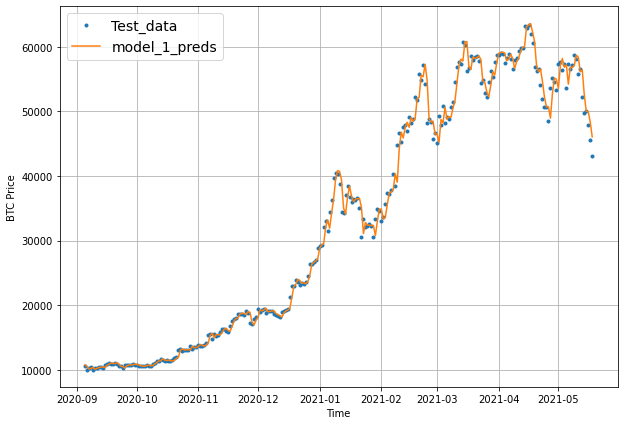

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

Compare the Naive and Dense Model results

In [ ]:
results = pd.DataFrame(
    {"naive_results":naive_results,
    "model1_results":model1_results
     }
).T

results

,mae,mse,rmse,mape,mase
naive_results,567.980225,1147547.0,1071.236206,2.516525,0.999570
model1_results,565.393982,1158886.5,1076.515869,2.523508,0.993241


The results of the Dense model are not great , can we experiment with other windows and horizons ?

###*Dense Model , WINDOW = 30 HORIZON = 1*

In [ ]:
WINDOW = 30
HORIZON = 1

In [ ]:
full_windows,full_labels = make_windows(prices,HORIZON=1,WINDOW=30)
len(full_windows),len(full_labels),len(full_windows[0]),len(full_labels[0])

(2757, 2757, 30, 1)

In [ ]:
train_windows,train_labels,test_windows,test_labels = split_into_train_and_test(full_windows,full_labels)
len(train_windows),len(train_labels),len(test_windows),len(test_labels)

(2205, 2205, 552, 552)

In [ ]:
tf.random.set_seed(42)

input_layer = tf.keras.layers.Input(shape=(30,))
dense_layer = tf.keras.layers.Dense(128,activation='relu')(input_layer)
output_layer = tf.keras.layers.Dense(HORIZON,activation='linear')(dense_layer)

model_2 = tf.keras.Model(input_layer,output_layer)

model_2.compile(
  loss = "mae",
  optimizer = tf.keras.optimizers.Adam(),
  metrics = ["mae"]   
)

model_2_history = model_2.fit(train_windows,train_labels,epochs=100,validation_data=(test_windows,test_labels),callbacks=[SaveBestWeights("checkpoints","model_2")])

Epoch 1/100
69/69 [==============================] - 1s 17ms/step - loss: 452.9576 - mae: 452.9576 - val_loss: 1612.2881 - val_mae: 1612.2881
Epoch 2/100
69/69 [==============================] - 1s 21ms/step - loss: 203.3974 - mae: 203.3974 - val_loss: 1515.4081 - val_mae: 1515.4081
Epoch 3/100
69/69 [==============================] - 1s 19ms/step - loss: 217.5898 - mae: 217.5898 - val_loss: 1220.6162 - val_mae: 1220.6162
Epoch 4/100
69/69 [==============================] - 0s 5ms/step - loss: 180.1548 - mae: 180.1548 - val_loss: 1447.4336 - val_mae: 1447.4336
Epoch 5/100
69/69 [==============================] - 1s 17ms/step - loss: 184.4209 - mae: 184.4209 - val_loss: 912.2101 - val_mae: 912.2101
Epoch 6/100
69/69 [==============================] - 0s 5ms/step - loss: 192.1391 - mae: 192.1391 - val_loss: 951.4958 - val_mae: 951.4958
Epoch 7/100
69/69 [==============================] - 0s 3ms/step - loss: 172.5896 - mae: 172.5896 - val_loss: 1028.5485 - val_mae: 1028.5485
Epoch 8/100
6

In [ ]:
model_2 = tf.keras.models.load_model('checkpoints/model_2')
model_2_preds = tf.squeeze(model_2.predict(test_windows))
#print(model_1_preds)
#print(tf.squeeze(test_labels))
model2_results = evaluate_preds(tf.squeeze(test_labels),model_2_preds)
model2_results

{'mae': 578.3928,
 'mape': 2.6382656,
 'mase': 1.0110364,
 'mse': 1183378.4,
 'rmse': 1087.8319}

Lets compare the results

In [ ]:
results = pd.DataFrame(
    {"naive_results":naive_results,
    "model1_results":model1_results,
    "model2_results":model2_results
     }
).T

results

,mae,mse,rmse,mape,mase
naive_results,567.980225,1147547.000,1071.236206,2.516525,0.999570
model1_results,565.393982,1158886.500,1076.515869,2.523508,0.993241
model2_results,578.392822,1183378.375,1087.831909,2.638266,1.011036


The performace has fallen , lets experiment with more variations of WINDOW and HORIZON

###*Dense Model , WINDOW = 30 HORIZON = 7*

In [ ]:
HORIZON = 7
WINDOW = 30
full_windows,full_labels = make_windows(prices,HORIZON,WINDOW)
len(full_windows),len(full_labels),len(full_windows[0]),len(full_labels[0])

(2751, 2751, 30, 7)

In [ ]:
train_windows,train_labels,test_windows,test_labels = split_into_train_and_test(full_windows,full_labels)
len(train_windows),len(train_labels),len(test_windows),len(test_labels)

(2200, 2200, 551, 551)

In [ ]:
tf.random.set_seed(42)

input_layer = tf.keras.layers.Input(shape=(WINDOW,))
dense_layer = tf.keras.layers.Dense(128,activation="relu")(input_layer)
output_layer = tf.keras.layers.Dense(HORIZON,activation="linear")(dense_layer)

model_3 = tf.keras.Model(input_layer,output_layer)

model_3.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae"]
)

model_3_history = model_3.fit(
    train_windows,
    train_labels,
    epochs=100,
    validation_data=(test_windows,test_labels),
    callbacks=[SaveBestWeights("checkpoints","model_3")]
)

Epoch 1/100
69/69 [==============================] - 1s 11ms/step - loss: 741.8990 - mae: 741.8990 - val_loss: 1965.7540 - val_mae: 1965.7540
Epoch 2/100
69/69 [==============================] - 1s 10ms/step - loss: 367.1797 - mae: 367.1797 - val_loss: 1801.1920 - val_mae: 1801.1920
Epoch 3/100
69/69 [==============================] - 1s 10ms/step - loss: 314.3243 - mae: 314.3243 - val_loss: 1710.5111 - val_mae: 1710.5111
Epoch 4/100
69/69 [==============================] - 1s 13ms/step - loss: 292.6830 - mae: 292.6830 - val_loss: 1500.6156 - val_mae: 1500.6156
Epoch 5/100
69/69 [==============================] - 0s 3ms/step - loss: 279.3596 - mae: 279.3596 - val_loss: 1838.0526 - val_mae: 1838.0526
Epoch 6/100
69/69 [==============================] - 0s 3ms/step - loss: 268.7655 - mae: 268.7655 - val_loss: 1563.0974 - val_mae: 1563.0974
Epoch 7/100
69/69 [==============================] - 1s 10ms/step - loss: 278.2786 - mae: 278.2786 - val_loss: 1393.0002 - val_mae: 1393.0002
Epoch 8/

The evaluate function has to be modified to take into account the new HORIZON size

In [ ]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
model_3 = tf.keras.models.load_model('checkpoints/model_3')
model_3_preds = tf.squeeze(model_3.predict(test_windows))
model3_results = evaluate_preds(tf.squeeze(test_labels),model_3_preds)
model3_results

{'mae': 1188.2096,
 'mape': 5.425085,
 'mase': 2.1143522,
 'mse': 5068380.0,
 'rmse': 1371.69}

In [ ]:
results = pd.DataFrame(
    {"naive_results":naive_results,
    "model1_results":model1_results,
    "model2_results":model2_results,
    "model3_results":model3_results
     }
).T

results

,mae,mse,rmse,mape,mase
naive_results,567.980225,1147547.000,1071.236206,2.516525,0.999570
model1_results,565.393982,1158886.500,1076.515869,2.523508,0.993241
model2_results,578.392822,1183378.375,1087.831909,2.638266,1.011036
model3_results,1188.209595,5068380.000,1371.689941,5.425085,2.114352


Performance has significantly dropped 

Lets expereiment with different permutations of the WINDOW and HORIZON

###*Different Combinations of Window and Horizon*

In [ ]:
results = pd.DataFrame()

Function to build,compile and fit a model 

In [ ]:
def build_compile_fit(results,HORIZON=1,WINDOW=7):

  full_windows,full_labels = make_windows(prices,HORIZON,WINDOW)
  print(len(full_windows),len(full_labels),len(full_windows[0]),len(full_labels[0]))

  train_windows,train_labels,test_windows,test_labels = split_into_train_and_test(full_windows,full_labels)
  print(len(train_windows),len(train_labels),len(test_windows),len(test_labels))


  tf.random.set_seed(42)

  input_layer = tf.keras.layers.Input(shape=(WINDOW,))
  dense_layer = tf.keras.layers.Dense(128,activation='relu')(input_layer)
  output_layer = tf.keras.layers.Dense(HORIZON,activation='linear')(dense_layer)

  model_name = "model_" + str(HORIZON) + "_" + str(WINDOW)
  print(model_name)
  model_temp = tf.keras.Model(input_layer,output_layer)

  model_temp.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae"]   
  )

  model_temp_history = model_temp.fit(train_windows,train_labels,epochs=100,verbose=0,validation_data=(test_windows,test_labels),callbacks=[SaveBestWeights("checkpoints",model_name)])

  model_temp = tf.keras.models.load_model('checkpoints/'+ model_name)
  model_temp_preds = tf.squeeze(model_temp.predict(test_windows))
  model_temp_results = evaluate_preds(tf.squeeze(test_labels),model_temp_preds)
  model_temp_results["WINDOW"] = WINDOW
  model_temp_results["HORIZON"] = HORIZON

  results = results.append(model_temp_results, ignore_index=True)

  return results
  #return model_temp_results

In [ ]:
for HORIZON in range(1,4):
  for WINDOW in range(7,2,-1):
    results = build_compile_fit(results,HORIZON,WINDOW)

2780 2780 7 1
2224 2224 556 556
model_1_7
INFO:tensorflow:Assets written to: checkpoints/model_1_7/assets
INFO:tensorflow:Assets written to: checkpoints/model_1_7/assets
INFO:tensorflow:Assets written to: checkpoints/model_1_7/assets
INFO:tensorflow:Assets written to: checkpoints/model_1_7/assets
INFO:tensorflow:Assets written to: checkpoints/model_1_7/assets
INFO:tensorflow:Assets written to: checkpoints/model_1_7/assets
INFO:tensorflow:Assets written to: checkpoints/model_1_7/assets
INFO:tensorflow:Assets written to: checkpoints/model_1_7/assets
INFO:tensorflow:Assets written to: checkpoints/model_1_7/assets
INFO:tensorflow:Assets written to: checkpoints/model_1_7/assets
INFO:tensorflow:Assets written to: checkpoints/model_1_7/assets
INFO:tensorflow:Assets written to: checkpoints/model_1_7/assets
INFO:tensorflow:Assets written to: checkpoints/model_1_7/assets
INFO:tensorflow:Assets written to: checkpoints/model_1_7/assets
INFO:tensorflow:Assets written to: checkpoints/model_1_7/asset

In [ ]:
results

,mae,mse,rmse,mape,mase,WINDOW,HORIZON
0,565.435242,1162501.375,1078.193604,2.524402,0.993313,7.0,1.0
1,563.744995,1144775.875,1069.942017,2.524285,0.992117,6.0,1.0
2,562.386780,1149740.125,1072.259277,2.520985,0.989726,5.0,1.0
3,563.719910,1139169.625,1067.318848,2.519957,0.992072,4.0,1.0
4,564.133606,1140695.750,1068.033569,2.519523,0.992800,3.0,1.0
5,690.507568,1715379.125,748.695618,3.100572,1.217765,7.0,2.0
6,687.979919,1705239.375,744.429871,3.086945,1.213307,6.0,2.0
7,689.631531,1706485.625,747.100037,3.084180,1.217568,5.0,2.0
8,687.321716,1694958.125,742.480835,3.084044,1.213490,4.0,2.0
9,685.746277,1688588.500,741.006409,3.081211,1.210709,3.0,2.0


###*Conv1D , WINDOW = 7 , HORIZON = 1*

In [ ]:
HORIZON = 1
WINDOW = 7
full_windows,full_labels = make_windows(prices,HORIZON,WINDOW)
len(full_windows),len(full_labels),len(full_windows[0]),len(full_labels[0])

(2780, 2780, 7, 1)

In [ ]:
train_windows,train_labels,test_windows,test_labels = split_into_train_and_test(full_windows,full_labels)
len(train_windows),len(train_labels),len(test_windows),len(test_labels)

(2224, 2224, 556, 556)

In [ ]:
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=1)),
      tf.keras.layers.Conv1D(filters=128,kernel_size=5,padding="causal",activation="relu"),
      tf.keras.layers.Dense(HORIZON)
])

model_4.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae"]
)

model_4_history = model_4.fit(
    train_windows,
    train_labels,
    epochs=100,
    validation_data=(test_windows,test_labels),
    callbacks=[SaveBestWeights("checkpoints","model_4")]
)

Epoch 1/100
70/70 [==============================] - 10s 16ms/step - loss: 490.4070 - mae: 490.4070 - val_loss: 968.9146 - val_mae: 968.9146
Epoch 2/100
70/70 [==============================] - 1s 13ms/step - loss: 172.2260 - mae: 172.2260 - val_loss: 914.2228 - val_mae: 914.2228
Epoch 3/100
70/70 [==============================] - 1s 17ms/step - loss: 166.2561 - mae: 166.2561 - val_loss: 873.7416 - val_mae: 873.7416
Epoch 4/100
70/70 [==============================] - 1s 13ms/step - loss: 154.1053 - mae: 154.1053 - val_loss: 798.7244 - val_mae: 798.7244
Epoch 5/100
70/70 [==============================] - 0s 4ms/step - loss: 144.7203 - mae: 144.7203 - val_loss: 808.0445 - val_mae: 808.0445
Epoch 6/100
70/70 [==============================] - 1s 13ms/step - loss: 136.9765 - mae: 136.9765 - val_loss: 722.9863 - val_mae: 722.9863
Epoch 7/100
70/70 [==============================] - 1s 13ms/step - loss: 136.7111 - mae: 136.7111 - val_loss: 720.3262 - val_mae: 720.3262
Epoch 8/100
70/70 [=

In [ ]:
model_4 = tf.keras.models.load_model('checkpoints/model_4')
model_4_preds = tf.squeeze(model_4.predict(test_windows))
model4_results = evaluate_preds(tf.squeeze(test_labels),model_4_preds)
model4_results

{'mae': 564.3295,
 'mape': 2.5248137,
 'mase': 0.9913707,
 'mse': 1156320.8,
 'rmse': 1075.3236}

In [ ]:
results = pd.DataFrame(
    {"naive_results":naive_results,
    "model1_results":model1_results,
    "model2_results":model2_results,
    "model3_results":model3_results,
    "model4_results":model4_results
     }
).T

results

,mae,mse,rmse,mape,mase
naive_results,567.980225,1147547.000,1071.236206,2.516525,0.999570
model1_results,565.393982,1158886.500,1076.515869,2.523508,0.993241
model2_results,578.392822,1183378.375,1087.831909,2.638266,1.011036
model3_results,1188.209595,5068380.000,1371.689941,5.425085,2.114352
model4_results,564.329529,1156320.750,1075.323608,2.524814,0.991371


###*RNN(LSTM)*

In [ ]:
HORIZON = 1
WINDOW = 7
full_windows,full_labels = make_windows(prices,HORIZON,WINDOW)
len(full_windows),len(full_labels),len(full_windows[0]),len(full_labels[0])

(2780, 2780, 7, 1)

In [ ]:
train_windows,train_labels,test_windows,test_labels = split_into_train_and_test(full_windows,full_labels)
len(train_windows),len(train_labels),len(test_windows),len(test_labels)

(2224, 2224, 556, 556)

In [ ]:
tf.random.set_seed(42)

model_5 = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x:tf.expand_dims(x,axis=1)),
    tf.keras.layers.LSTM(128,activation="relu"),
    tf.keras.layers.Lambda(lambda x:tf.expand_dims(x,axis=1)),
    tf.keras.layers.LSTM(128,activation="relu"),
    tf.keras.layers.Dense(HORIZON)
])

model_5.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae"]
)

model_5_history = model_5.fit(
    train_windows,
    train_labels,
    epochs=100,
    validation_data=(test_windows,test_labels),
    callbacks=[SaveBestWeights("checkpoints","model_5")]
)

Epoch 1/100
67/70 [===========================>..] - ETA: 0s - loss: 1189.6937 - mae: 1189.6937INFO:tensorflow:Assets written to: checkpoints/model_5/assets


70/70 [==============================] - 7s 65ms/step - loss: 1152.0074 - mae: 1152.0074 - val_loss: 1023.1381 - val_mae: 1023.1381
Epoch 2/100
68/70 [============================>.] - ETA: 0s - loss: 166.7672 - mae: 166.7672INFO:tensorflow:Assets written to: checkpoints/model_5/assets


INFO:tensorflow:Assets written to: checkpoints/model_5/assets


70/70 [==============================] - 4s 60ms/step - loss: 165.1075 - mae: 165.1075 - val_loss: 897.5225 - val_mae: 897.5225
Epoch 3/100
69/70 [============================>.] - ETA: 0s - loss: 167.3971 - mae: 167.3971INFO:tensorflow:Assets written to: checkpoints/model_5/assets


INFO:tensorflow:Assets written to: checkpoints/model_5/assets


70/70 [==============================] - 4s 55ms/step - loss: 166.5351 - mae: 166.5351 - val_loss: 853.5387 - val_mae: 853.5387
Epoch 4/100
69/70 [============================>.] - ETA: 0s - loss: 156.6103 - mae: 156.6103INFO:tensorflow:Assets written to: checkpoints/model_5/assets


INFO:tensorflow:Assets written to: checkpoints/model_5/assets


70/70 [==============================] - 4s 56ms/step - loss: 155.9115 - mae: 155.9115 - val_loss: 826.7631 - val_mae: 826.7631
Epoch 5/100
69/70 [============================>.] - ETA: 0s - loss: 148.8569 - mae: 148.8569INFO:tensorflow:Assets written to: checkpoints/model_5/assets


INFO:tensorflow:Assets written to: checkpoints/model_5/assets


70/70 [==============================] - 4s 62ms/step - loss: 148.5977 - mae: 148.5977 - val_loss: 811.7111 - val_mae: 811.7111
Epoch 6/100
68/70 [============================>.] - ETA: 0s - loss: 147.2541 - mae: 147.2541INFO:tensorflow:Assets written to: checkpoints/model_5/assets


INFO:tensorflow:Assets written to: checkpoints/model_5/assets


70/70 [==============================] - 4s 56ms/step - loss: 149.0337 - mae: 149.0337 - val_loss: 770.8712 - val_mae: 770.8712
Epoch 7/100
70/70 [==============================] - 1s 10ms/step - loss: 145.1759 - mae: 145.1759 - val_loss: 805.8633 - val_mae: 805.8633
Epoch 8/100
68/70 [============================>.] - ETA: 0s - loss: 147.1918 - mae: 147.1918INFO:tensorflow:Assets written to: checkpoints/model_5/assets


INFO:tensorflow:Assets written to: checkpoints/model_5/assets


70/70 [==============================] - 4s 62ms/step - loss: 146.8372 - mae: 146.8372 - val_loss: 758.3733 - val_mae: 758.3733
Epoch 9/100
70/70 [==============================] - 1s 10ms/step - loss: 135.4850 - mae: 135.4850 - val_loss: 797.1474 - val_mae: 797.1474
Epoch 10/100
70/70 [==============================] - ETA: 0s - loss: 148.8062 - mae: 148.8062INFO:tensorflow:Assets written to: checkpoints/model_5/assets


INFO:tensorflow:Assets written to: checkpoints/model_5/assets


70/70 [==============================] - 8s 109ms/step - loss: 148.8062 - mae: 148.8062 - val_loss: 702.9771 - val_mae: 702.9771
Epoch 11/100
70/70 [==============================] - 2s 28ms/step - loss: 134.8059 - mae: 134.8059 - val_loss: 744.9982 - val_mae: 744.9982
Epoch 12/100
70/70 [==============================] - 2s 29ms/step - loss: 125.7769 - mae: 125.7769 - val_loss: 737.3474 - val_mae: 737.3474
Epoch 13/100
70/70 [==============================] - ETA: 0s - loss: 125.3793 - mae: 125.3793INFO:tensorflow:Assets written to: checkpoints/model_5/assets


INFO:tensorflow:Assets written to: checkpoints/model_5/assets


70/70 [==============================] - 14s 204ms/step - loss: 125.3793 - mae: 125.3793 - val_loss: 688.3046 - val_mae: 688.3046
Epoch 14/100
70/70 [==============================] - 2s 24ms/step - loss: 132.3034 - mae: 132.3034 - val_loss: 1087.2834 - val_mae: 1087.2834
Epoch 15/100
68/70 [============================>.] - ETA: 0s - loss: 133.0252 - mae: 133.0252INFO:tensorflow:Assets written to: checkpoints/model_5/assets


INFO:tensorflow:Assets written to: checkpoints/model_5/assets


70/70 [==============================] - 8s 122ms/step - loss: 132.9570 - mae: 132.9570 - val_loss: 677.8636 - val_mae: 677.8636
Epoch 16/100
70/70 [==============================] - ETA: 0s - loss: 122.8073 - mae: 122.8073INFO:tensorflow:Assets written to: checkpoints/model_5/assets


INFO:tensorflow:Assets written to: checkpoints/model_5/assets


70/70 [==============================] - 8s 111ms/step - loss: 122.8073 - mae: 122.8073 - val_loss: 629.8291 - val_mae: 629.8291
Epoch 17/100
70/70 [==============================] - 1s 21ms/step - loss: 121.1732 - mae: 121.1732 - val_loss: 633.7279 - val_mae: 633.7279
Epoch 18/100
70/70 [==============================] - ETA: 0s - loss: 120.5823 - mae: 120.5823INFO:tensorflow:Assets written to: checkpoints/model_5/assets


INFO:tensorflow:Assets written to: checkpoints/model_5/assets


70/70 [==============================] - 8s 113ms/step - loss: 120.5823 - mae: 120.5823 - val_loss: 616.9390 - val_mae: 616.9390
Epoch 19/100
70/70 [==============================] - 1s 17ms/step - loss: 122.5942 - mae: 122.5942 - val_loss: 621.6888 - val_mae: 621.6888
Epoch 20/100
70/70 [==============================] - 2s 23ms/step - loss: 117.4987 - mae: 117.4987 - val_loss: 662.3796 - val_mae: 662.3796
Epoch 21/100
70/70 [==============================] - ETA: 0s - loss: 121.1777 - mae: 121.1777INFO:tensorflow:Assets written to: checkpoints/model_5/assets


INFO:tensorflow:Assets written to: checkpoints/model_5/assets


70/70 [==============================] - 7s 104ms/step - loss: 121.1777 - mae: 121.1777 - val_loss: 612.3702 - val_mae: 612.3702
Epoch 22/100
70/70 [==============================] - 1s 10ms/step - loss: 121.0218 - mae: 121.0218 - val_loss: 661.4570 - val_mae: 661.4570
Epoch 23/100
70/70 [==============================] - 1s 10ms/step - loss: 120.9264 - mae: 120.9264 - val_loss: 620.0123 - val_mae: 620.0123
Epoch 24/100
66/70 [===========================>..] - ETA: 0s - loss: 118.8997 - mae: 118.8997INFO:tensorflow:Assets written to: checkpoints/model_5/assets


INFO:tensorflow:Assets written to: checkpoints/model_5/assets


70/70 [==============================] - 4s 55ms/step - loss: 117.7293 - mae: 117.7293 - val_loss: 601.0217 - val_mae: 601.0217
Epoch 25/100
70/70 [==============================] - 1s 9ms/step - loss: 122.4974 - mae: 122.4974 - val_loss: 640.1457 - val_mae: 640.1457
Epoch 26/100
67/70 [===========================>..] - ETA: 0s - loss: 122.9289 - mae: 122.9289INFO:tensorflow:Assets written to: checkpoints/model_5/assets


INFO:tensorflow:Assets written to: checkpoints/model_5/assets


70/70 [==============================] - 5s 72ms/step - loss: 122.8519 - mae: 122.8519 - val_loss: 596.0239 - val_mae: 596.0239
Epoch 27/100
70/70 [==============================] - 1s 12ms/step - loss: 118.4270 - mae: 118.4270 - val_loss: 814.4612 - val_mae: 814.4612
Epoch 28/100
70/70 [==============================] - 1s 9ms/step - loss: 121.5188 - mae: 121.5188 - val_loss: 601.1694 - val_mae: 601.1694
Epoch 29/100
70/70 [==============================] - 1s 9ms/step - loss: 118.4524 - mae: 118.4524 - val_loss: 642.1265 - val_mae: 642.1265
Epoch 30/100
67/70 [===========================>..] - ETA: 0s - loss: 116.5093 - mae: 116.5093INFO:tensorflow:Assets written to: checkpoints/model_5/assets


INFO:tensorflow:Assets written to: checkpoints/model_5/assets


70/70 [==============================] - 4s 56ms/step - loss: 117.2811 - mae: 117.2811 - val_loss: 592.0192 - val_mae: 592.0192
Epoch 31/100
70/70 [==============================] - 1s 10ms/step - loss: 116.6003 - mae: 116.6003 - val_loss: 822.5569 - val_mae: 822.5569
Epoch 32/100
67/70 [===========================>..] - ETA: 0s - loss: 123.1645 - mae: 123.1645INFO:tensorflow:Assets written to: checkpoints/model_5/assets


INFO:tensorflow:Assets written to: checkpoints/model_5/assets


70/70 [==============================] - 4s 59ms/step - loss: 124.1358 - mae: 124.1358 - val_loss: 586.2313 - val_mae: 586.2313
Epoch 33/100
70/70 [==============================] - 1s 10ms/step - loss: 121.2632 - mae: 121.2632 - val_loss: 805.2260 - val_mae: 805.2260
Epoch 34/100
70/70 [==============================] - 1s 10ms/step - loss: 123.5724 - mae: 123.5724 - val_loss: 624.8470 - val_mae: 624.8470
Epoch 35/100
67/70 [===========================>..] - ETA: 0s - loss: 112.6877 - mae: 112.6877INFO:tensorflow:Assets written to: checkpoints/model_5/assets


INFO:tensorflow:Assets written to: checkpoints/model_5/assets


70/70 [==============================] - 4s 64ms/step - loss: 112.9287 - mae: 112.9287 - val_loss: 584.2656 - val_mae: 584.2656
Epoch 36/100
70/70 [==============================] - 1s 10ms/step - loss: 111.3024 - mae: 111.3024 - val_loss: 717.3480 - val_mae: 717.3480
Epoch 37/100
70/70 [==============================] - 1s 9ms/step - loss: 118.3712 - mae: 118.3712 - val_loss: 595.9551 - val_mae: 595.9551
Epoch 38/100
70/70 [==============================] - 1s 9ms/step - loss: 123.8517 - mae: 123.8517 - val_loss: 729.3179 - val_mae: 729.3179
Epoch 39/100
70/70 [==============================] - 1s 10ms/step - loss: 116.6337 - mae: 116.6337 - val_loss: 627.6429 - val_mae: 627.6429
Epoch 40/100
70/70 [==============================] - 1s 9ms/step - loss: 115.2553 - mae: 115.2553 - val_loss: 649.3985 - val_mae: 649.3985
Epoch 41/100
70/70 [==============================] - 1s 9ms/step - loss: 113.0508 - mae: 113.0508 - val_loss: 869.1957 - val_mae: 869.1957
Epoch 42/100
70/70 [==========

INFO:tensorflow:Assets written to: checkpoints/model_5/assets


70/70 [==============================] - 4s 54ms/step - loss: 115.2153 - mae: 115.2153 - val_loss: 580.9828 - val_mae: 580.9828
Epoch 43/100
70/70 [==============================] - 1s 10ms/step - loss: 117.5128 - mae: 117.5128 - val_loss: 608.3362 - val_mae: 608.3362
Epoch 44/100
70/70 [==============================] - 1s 9ms/step - loss: 117.2717 - mae: 117.2717 - val_loss: 639.3772 - val_mae: 639.3772
Epoch 45/100
66/70 [===========================>..] - ETA: 0s - loss: 116.1828 - mae: 116.1828INFO:tensorflow:Assets written to: checkpoints/model_5/assets


INFO:tensorflow:Assets written to: checkpoints/model_5/assets


70/70 [==============================] - 4s 61ms/step - loss: 116.9608 - mae: 116.9608 - val_loss: 577.5229 - val_mae: 577.5229
Epoch 46/100
70/70 [==============================] - 1s 9ms/step - loss: 124.2783 - mae: 124.2783 - val_loss: 646.7717 - val_mae: 646.7717
Epoch 47/100
70/70 [==============================] - 1s 9ms/step - loss: 113.7038 - mae: 113.7038 - val_loss: 971.1089 - val_mae: 971.1089
Epoch 48/100
70/70 [==============================] - 1s 9ms/step - loss: 141.8593 - mae: 141.8593 - val_loss: 789.6980 - val_mae: 789.6980
Epoch 49/100
70/70 [==============================] - 1s 10ms/step - loss: 127.1206 - mae: 127.1206 - val_loss: 609.6972 - val_mae: 609.6972
Epoch 50/100
70/70 [==============================] - 1s 9ms/step - loss: 115.8225 - mae: 115.8225 - val_loss: 610.1441 - val_mae: 610.1441
Epoch 51/100
69/70 [============================>.] - ETA: 0s - loss: 114.6499 - mae: 114.6499INFO:tensorflow:Assets written to: checkpoints/model_5/assets


INFO:tensorflow:Assets written to: checkpoints/model_5/assets


70/70 [==============================] - 4s 56ms/step - loss: 114.9018 - mae: 114.9018 - val_loss: 574.5831 - val_mae: 574.5831
Epoch 52/100
70/70 [==============================] - 1s 10ms/step - loss: 117.4233 - mae: 117.4233 - val_loss: 617.8981 - val_mae: 617.8981
Epoch 53/100
70/70 [==============================] - 1s 10ms/step - loss: 113.0383 - mae: 113.0383 - val_loss: 622.2573 - val_mae: 622.2573
Epoch 54/100
70/70 [==============================] - 1s 10ms/step - loss: 112.6352 - mae: 112.6352 - val_loss: 598.2776 - val_mae: 598.2776
Epoch 55/100
70/70 [==============================] - 1s 10ms/step - loss: 114.1411 - mae: 114.1411 - val_loss: 583.1500 - val_mae: 583.1500
Epoch 56/100
70/70 [==============================] - 1s 10ms/step - loss: 110.0699 - mae: 110.0699 - val_loss: 660.1774 - val_mae: 660.1774
Epoch 57/100
70/70 [==============================] - 1s 10ms/step - loss: 111.9840 - mae: 111.9840 - val_loss: 724.9157 - val_mae: 724.9157
Epoch 58/100
70/70 [======

INFO:tensorflow:Assets written to: checkpoints/model_5/assets


70/70 [==============================] - 4s 62ms/step - loss: 111.5337 - mae: 111.5337 - val_loss: 573.9169 - val_mae: 573.9169
Epoch 60/100
70/70 [==============================] - 1s 9ms/step - loss: 112.9664 - mae: 112.9664 - val_loss: 574.1793 - val_mae: 574.1793
Epoch 61/100
70/70 [==============================] - 1s 9ms/step - loss: 111.7671 - mae: 111.7671 - val_loss: 627.4987 - val_mae: 627.4987
Epoch 62/100
70/70 [==============================] - 1s 9ms/step - loss: 112.0525 - mae: 112.0525 - val_loss: 672.4003 - val_mae: 672.4003
Epoch 63/100
65/70 [==========================>...] - ETA: 0s - loss: 120.7473 - mae: 120.7473INFO:tensorflow:Assets written to: checkpoints/model_5/assets


INFO:tensorflow:Assets written to: checkpoints/model_5/assets


70/70 [==============================] - 4s 55ms/step - loss: 118.6774 - mae: 118.6774 - val_loss: 570.2340 - val_mae: 570.2340
Epoch 64/100
70/70 [==============================] - 1s 10ms/step - loss: 120.8877 - mae: 120.8877 - val_loss: 618.1848 - val_mae: 618.1848
Epoch 65/100
70/70 [==============================] - 1s 10ms/step - loss: 116.4445 - mae: 116.4445 - val_loss: 698.0010 - val_mae: 698.0010
Epoch 66/100
70/70 [==============================] - 1s 10ms/step - loss: 112.0093 - mae: 112.0093 - val_loss: 591.0756 - val_mae: 591.0756
Epoch 67/100
70/70 [==============================] - 1s 9ms/step - loss: 111.7059 - mae: 111.7059 - val_loss: 573.7896 - val_mae: 573.7896
Epoch 68/100
70/70 [==============================] - 1s 10ms/step - loss: 111.4023 - mae: 111.4023 - val_loss: 638.7974 - val_mae: 638.7974
Epoch 69/100
70/70 [==============================] - 1s 10ms/step - loss: 111.9271 - mae: 111.9271 - val_loss: 624.3491 - val_mae: 624.3491
Epoch 70/100
70/70 [=======

INFO:tensorflow:Assets written to: checkpoints/model_5/assets


70/70 [==============================] - 4s 63ms/step - loss: 111.7248 - mae: 111.7248 - val_loss: 569.1089 - val_mae: 569.1089
Epoch 78/100
70/70 [==============================] - 1s 10ms/step - loss: 111.2562 - mae: 111.2562 - val_loss: 613.4463 - val_mae: 613.4463
Epoch 79/100
70/70 [==============================] - 1s 10ms/step - loss: 130.7716 - mae: 130.7716 - val_loss: 577.5146 - val_mae: 577.5146
Epoch 80/100
70/70 [==============================] - 1s 10ms/step - loss: 113.2731 - mae: 113.2731 - val_loss: 569.3109 - val_mae: 569.3109
Epoch 81/100
70/70 [==============================] - 1s 10ms/step - loss: 115.1543 - mae: 115.1543 - val_loss: 688.1265 - val_mae: 688.1265
Epoch 82/100
70/70 [==============================] - 1s 10ms/step - loss: 119.3146 - mae: 119.3146 - val_loss: 655.3286 - val_mae: 655.3286
Epoch 83/100
70/70 [==============================] - 1s 9ms/step - loss: 111.1758 - mae: 111.1758 - val_loss: 608.5251 - val_mae: 608.5251
Epoch 84/100
70/70 [=======

INFO:tensorflow:Assets written to: checkpoints/model_5/assets


70/70 [==============================] - 4s 57ms/step - loss: 111.9221 - mae: 111.9221 - val_loss: 568.2008 - val_mae: 568.2008
Epoch 98/100
70/70 [==============================] - 1s 9ms/step - loss: 124.2532 - mae: 124.2532 - val_loss: 614.8315 - val_mae: 614.8315
Epoch 99/100
70/70 [==============================] - 1s 9ms/step - loss: 112.6797 - mae: 112.6797 - val_loss: 635.8770 - val_mae: 635.8770
Epoch 100/100
70/70 [==============================] - 1s 11ms/step - loss: 119.2398 - mae: 119.2398 - val_loss: 713.3541 - val_mae: 713.3541


In [ ]:
model_5 = tf.keras.models.load_model("checkpoints/model_5")
model_5_preds = tf.squeeze(model_5.predict(test_windows))
model5_results = evaluate_preds(tf.squeeze(test_labels),model_5_preds)
model5_results

{'mae': 568.2008,
 'mape': 2.5375922,
 'mase': 0.99817145,
 'mse': 1166412.1,
 'rmse': 1080.0056}

In [ ]:
results = pd.DataFrame(
    {"naive_results":naive_results,
    "model1_results":model1_results,
    "model2_results":model2_results,
    "model3_results":model3_results,
    "model4_results":model4_results,
    "model5_results":model5_results
     }
).T

results

,mae,mse,rmse,mape,mase
naive_results,567.980225,1147547.000,1071.236206,2.516525,0.999570
model1_results,565.393982,1158886.500,1076.515869,2.523508,0.993241
model2_results,578.392822,1183378.375,1087.831909,2.638266,1.011036
model3_results,1188.209595,5068380.000,1371.689941,5.425085,2.114352
model4_results,564.329529,1156320.750,1075.323608,2.524814,0.991371
model5_results,568.200806,1166412.125,1080.005615,2.537592,0.998171


###*Multivariate Data Model*

####Preparing Multivariate Data

In [ ]:
import numpy as np

# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [ ]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [ ]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,prices,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


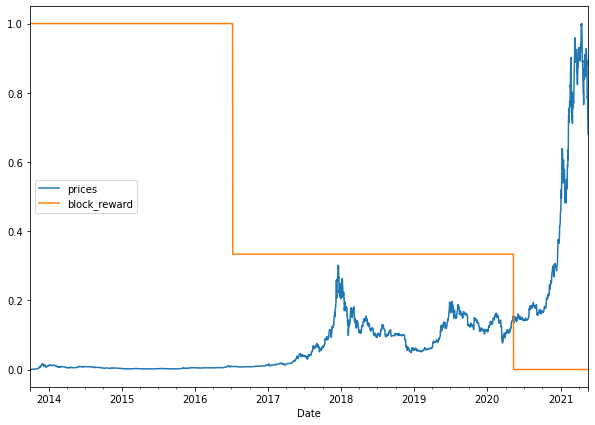

In [ ]:
from sklearn.preprocessing import minmax_scale

scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["prices", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)

scaled_price_block_df.plot(figsize=(10,7))

In [ ]:
HORIZON = 1
WINDOW = 7

In [ ]:
bitcoin_prices_block_windowed = bitcoin_prices_block.copy()

for i in range(WINDOW):
  bitcoin_prices_block_windowed[f"Price+{i+1}"] = bitcoin_prices_block_windowed["prices"].shift(periods=i+1)
bitcoin_prices_block_windowed.head(10)

,prices,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [ ]:
X = bitcoin_prices_block_windowed.dropna().drop("prices",axis=1).astype(np.float32)
y = bitcoin_prices_block_windowed.dropna()["prices"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [ ]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: prices, dtype: float32

In [ ]:
split_size = int(0.8*(len(X)))

X_train,X_test = X[:split_size],X[split_size:]
y_train,y_test = y[:split_size],y[split_size:]

len(X_train),len(X_test),len(y_train),len(y_test)

(2224, 556, 2224, 556)

####Dense Multivariate Model

In [ ]:
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([
      tf.keras.layers.Dense(128,activation="relu"),
      tf.keras.layers.Dense(128,activation="relu"),
      tf.keras.layers.Dense(HORIZON)
])

model_6.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae"]
)

model_6_history = model_6.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=100,
    verbose=0,
    validation_data=(X_test,y_test),
    callbacks = [SaveBestWeights("checkpoints","model_6")]
)

INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


INFO:tensorflow:Assets written to: checkpoints/model_6/assets


In [ ]:
model_6 = tf.keras.models.load_model("checkpoints/model_6")
model_6_preds = tf.squeeze(model_6.predict(X_test))
model6_results = evaluate_preds(y_test,model_6_preds)
model6_results

{'mae': 568.81195,
 'mape': 2.553627,
 'mase': 0.99924505,
 'mse': 1164400.5,
 'rmse': 1079.0739}

In [ ]:
results = pd.DataFrame(
    {"naive_results":naive_results,
    "model1_results":model1_results,
    "model2_results":model2_results,
    "model3_results":model3_results,
    "model4_results":model4_results,
    "model5_results":model5_results,
    "model6_results":model6_results
     }
).T

results

,mae,mse,rmse,mape,mase
naive_results,567.980225,1147547.000,1071.236206,2.516525,0.999570
model1_results,565.393982,1158886.500,1076.515869,2.523508,0.993241
model2_results,578.392822,1183378.375,1087.831909,2.638266,1.011036
model3_results,1188.209595,5068380.000,1371.689941,5.425085,2.114352
model4_results,564.329529,1156320.750,1075.323608,2.524814,0.991371
model5_results,568.200806,1166412.125,1080.005615,2.537592,0.998171
model6_results,568.811951,1164400.500,1079.073853,2.553627,0.999245


###*N Beats Algorithm*

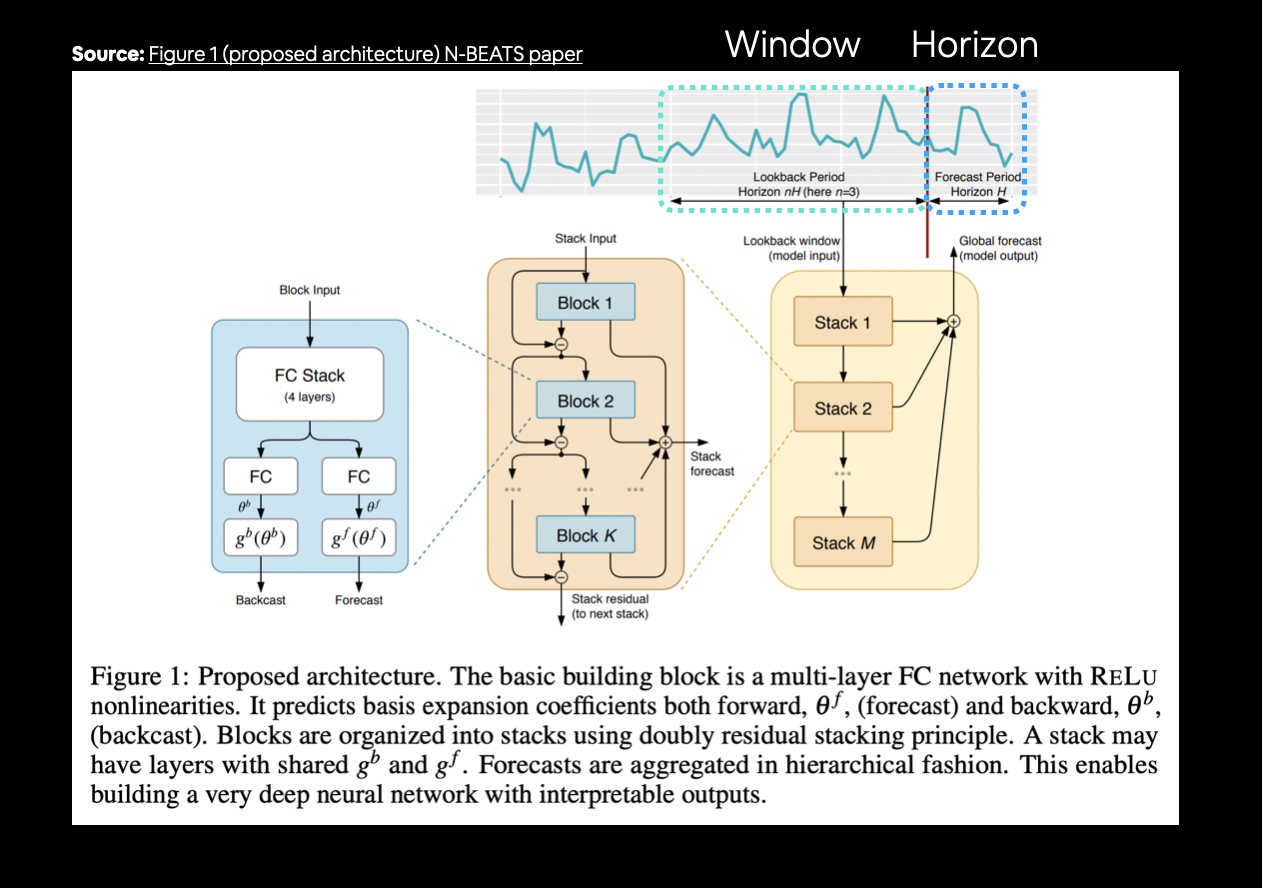

In [ ]:
WINDOW_SIZE = 7
HORIZON = 1

In [ ]:
class NBeatsBlock(tf.keras.layers.Layer):

  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(self.n_neurons,activation="relu") for i in range(self.n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size,activation="linear",name="theta")

  def call(self,inputs):
      x = inputs
      for layer in self.hidden:
        x = layer(x)

      theta = self.theta_layer(x)

      backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
      return backcast, forecast

In [ ]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1,axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
backcast,forecast = dummy_nbeats_block_layer(dummy_inputs)

print(f"""
    backcast {backcast.numpy()}
    forecast {forecast.numpy()}
""")


    backcast [[-0.46348703  0.10944437 -0.43355325  0.936024   -0.35703513 -0.17927606
  -0.34048352]]
    forecast [[-0.43979004]]



In [ ]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()

for i in range(WINDOW):
  bitcoin_prices_nbeats[f"Prices{i+1}"] = bitcoin_prices_nbeats["prices"].shift(periods=i+1)

bitcoin_prices_nbeats.head()

,prices,Prices1,Prices2,Prices3,Prices4,Prices5,Prices6,Prices7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
X = bitcoin_prices_nbeats.dropna().drop("prices",axis=1)
y = bitcoin_prices_nbeats.dropna()["prices"]

X.head()

,Prices1,Prices2,Prices3,Prices4,Prices5,Prices6,Prices7
Date,,,,,,,
2013-10-08,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [ ]:
y.head()

Date
2013-10-08    123.03300
2013-10-09    124.04900
2013-10-10    125.96116
2013-10-11    125.27966
2013-10-12    125.92750
Name: prices, dtype: float64

In [ ]:
split_size = int(0.8*len(X))

X_train = X[:split_size]
y_train = y[:split_size]

X_test = X[split_size:]
y_test = y[split_size:]

len(X_train),len(y_train),len(X_test),len(y_test)

(2224, 2224, 556, 556)

In [ ]:
import tensorflow as tf

X_train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
X_test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
y_train_dataset = tf.data.Dataset.from_tensor_slices(y_train)
y_test_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((X_train_dataset,y_train_dataset))
test_dataset = tf.data.Dataset.zip((X_test_dataset,y_test_dataset))

BATCH_SIZE = 1024 

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

The params will be set according to the NBeats paper

In [ ]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [ ]:
%%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174 
residuals = tf.keras.layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 438: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 538: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 1min 34s, sys: 2.26 s, total: 1min 37s
Wall time: 1min 54s


In [ ]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [ ]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8925.881, 8843.996, 9024.113, 8770.719, 8796.919, 8813.566,
       8634.694, 8536.122, 8506.927, 8514.163], dtype=float32)>

In [ ]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 573.7868,
 'mape': 2.5906014,
 'mase': 1.0079845,
 'mse': 1140930.6,
 'rmse': 1068.1436}

In [ ]:
results = pd.DataFrame(
    {"naive_results":naive_results,
    "model1_results":model1_results,
    "model2_results":model2_results,
    "model3_results":model3_results,
    "model4_results":model4_results,
    "model5_results":model5_results,
    "model6_results":model6_results,
    "model_7_results":model_7_results
     }
).T

results

,mae,mse,rmse,mape,mase
naive_results,567.980225,1147547.000,1071.236206,2.516525,0.999570
model1_results,565.393982,1158886.500,1076.515869,2.523508,0.993241
model2_results,578.392822,1183378.375,1087.831909,2.638266,1.011036
model3_results,1188.209595,5068380.000,1371.689941,5.425085,2.114352
model4_results,564.329529,1156320.750,1075.323608,2.524814,0.991371
model5_results,568.200806,1166412.125,1080.005615,2.537592,0.998171
model6_results,568.811951,1164400.500,1079.073853,2.553627,0.999245
model_7_results,573.786804,1140930.625,1068.143555,2.590601,1.007985


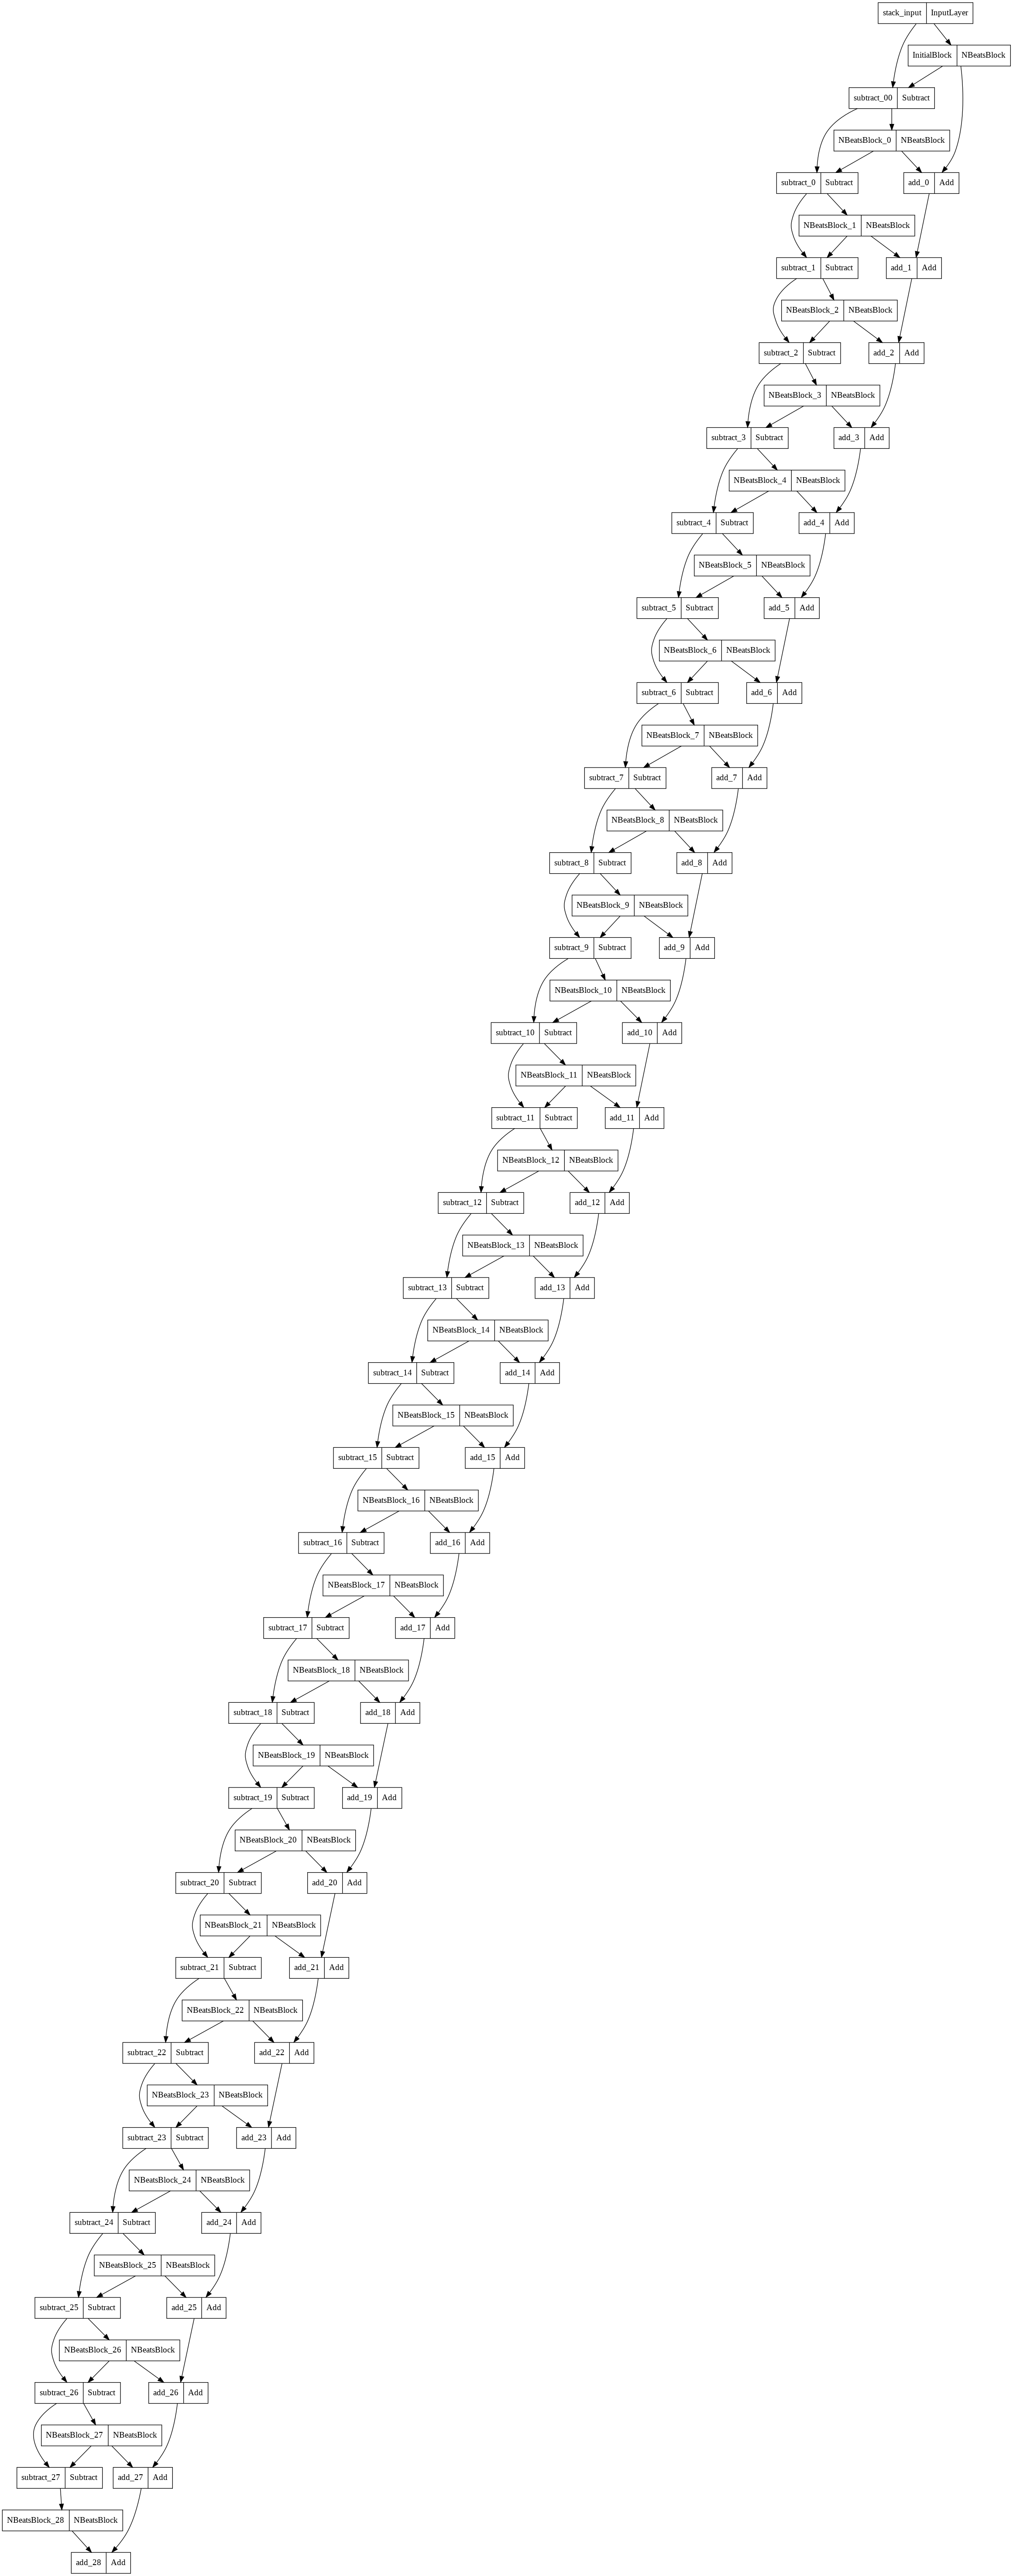

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_7)

###*Ensemble Model*

In [ ]:
from tensorflow.keras import layers

def get_ensemble_models(horizon=HORIZON, 
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10, 
                        num_epochs=100, 
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"), 
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)                                 
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

In [ ]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 896: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 499: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 168: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 268: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 409: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 509: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 1

Epoch 177: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mae fo

In [ ]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8795.477,  8768.243,  9033.053, ..., 50133.863, 49209.562,
        46651.695],
       [ 8737.267,  8722.299,  9038.799, ..., 49304.125, 48632.234,
        45484.23 ],
       [ 8745.424,  8733.034,  9101.386, ..., 49267.164, 47660.426,
        45370.047],
       ...,
       [ 8974.802,  8807.834,  9083.043, ..., 49684.32 , 49944.254,
        46702.99 ],
       [ 8729.521,  8806.002,  9103.141, ..., 49588.965, 48535.18 ,
        45059.67 ],
       [ 8815.888,  8760.738,  9040.152, ..., 49717.715, 48045.277,
        45825.688]], dtype=float32)>

In [ ]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 565.84735,
 'mape': 2.573646,
 'mase': 0.9940371,
 'mse': 1141935.6,
 'rmse': 1068.6139}

####Plotting the prediction intervals (uncertainty estimates) of our ensemble


One way of getting the 95% condfidnece prediction intervals for a deep learning model is the bootstrap method:

Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble model)

Measure the standard deviation of the predictions

Multiply standard deviation by 1.96 (assuming the distribution is Gaussian, 95% of observations fall within 1.96 standard deviations of the mean, this is why we initialized our neural networks with a normal distribution)

To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)

In [ ]:
def get_upper_lower(pred):
  std = tf.math.reduce_std(pred,axis=0)
  std = std*1.96

  mean = tf.math.reduce_mean(pred,axis=0)
  lower,upper = (mean-std),(mean+std)

  return lower,upper

lower,upper = get_upper_lower(ensemble_preds)

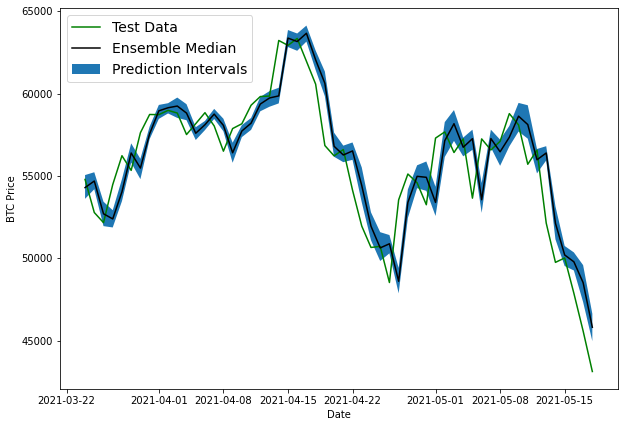

In [ ]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], 
                 (lower)[offset:], 
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

We've just plotted:

The test data (the ground truth Bitcoin prices)
The median of the ensemble predictions
The 95% prediction intervals (assuming the data is Gaussian/normal, the model is saying that 95% of the time, predicted value should fall between this range)
What can you tell about the ensemble model from the plot above?

It looks like the ensemble predictions are lagging slightly behind the actual data.

And the prediction intervals are fairly low throughout.

The combination of lagging predictions as well as low prediction intervals indicates that our ensemble model may be overfitting the data, meaning it's basically replicating what a naïve model would do and just predicting the previous timestep value for the next value.

This would explain why previous attempts to beat the naïve forecast have been futile.

In [ ]:
results = pd.DataFrame(
    {"naive_results":naive_results,
    "model1_results":model1_results,
    "model2_results":model2_results,
    "model3_results":model3_results,
    "model4_results":model4_results,
    "model5_results":model5_results,
    "model6_results":model6_results,
    "model_7_results":model_7_results,
    "ensemble_results":ensemble_results
     }
).T

results

,mae,mse,rmse,mape,mase
naive_results,567.980225,1147547.000,1071.236206,2.516525,0.999570
model1_results,565.393982,1158886.500,1076.515869,2.523508,0.993241
model2_results,578.392822,1183378.375,1087.831909,2.638266,1.011036
model3_results,1188.209595,5068380.000,1371.689941,5.425085,2.114352
model4_results,564.329529,1156320.750,1075.323608,2.524814,0.991371
model5_results,568.200806,1166412.125,1080.005615,2.537592,0.998171
model6_results,568.811951,1164400.500,1079.073853,2.553627,0.999245
model_7_results,573.786804,1140930.625,1068.143555,2.590601,1.007985
ensemble_results,565.847351,1141935.625,1068.613892,2.573646,0.994037


###*Neural Prophet*

In [ ]:
#Use (!pip)if it did not install
!pip install neuralprophet
#Live version(more features)if you are going to use the Jupyter
!pip install neuralprophet[live]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 74 kB 2.6 MB/s 
     |████████████████████████████████| 179 kB 23.4 MB/s 
  Attempting uninstall: holidays
    Found existing installation: holidays 0.10.5.2
    Uninstalling holidays-0.10.5.2:
      Successfully uninstalled holidays-0.10.5.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 6.7 MB/s 
     |████████████████████████████████| 793 kB 63.0 MB/s 
     |████████████████████████████████| 793 kB 50.6 MB/s 
     |████████████████████████████████| 792 kB 56.3 MB/s 
     |████████████████████████████████| 792 kB 53.7 MB/s 
     |████████████████████████████████| 791 kB 47.9 MB/s 
     |████████████████████████████████| 790 kB 56.8 MB/s 
     |████████████████████████████████| 788 kB 56.8 MB/s 
     |████████████████████████████████| 787 kB 59.7 MB/s 
     |████████████████████████████████| 786 kB 41.8 MB/s 
     |████████████████████████████████| 786 kB 60.8 MB/s 
     |████████████████████████████████| 785 kB 59.3 MB/s 
     |████████████████████████████████| 785 kB 64.2 MB/s 
     |████████████████████████████████| 785 kB 55.2 MB/s 
     |████████████████████████████████| 785 kB 55.1 MB/s 
     |██████████████████████████

In [ ]:
from neuralprophet import NeuralProphet

In [ ]:
import pandas as pd

df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv")
df.head(5)

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2013-10-01,123.65499,124.30466,124.75166,122.56349
1,BTC,2013-10-02,125.45500,123.65499,125.75850,123.63383
2,BTC,2013-10-03,108.58483,125.45500,125.66566,83.32833
3,BTC,2013-10-04,118.67466,108.58483,118.67500,107.05816
4,BTC,2013-10-05,121.33866,118.67466,121.93633,118.00566


In [ ]:
bitcoin_prices = df[["Closing Price (USD)","Date"]].rename(columns = {"Date":"ds","Closing Price (USD)":"y"})
bitcoin_prices.head()

,y,ds
0,123.65499,2013-10-01
1,125.45500,2013-10-02
2,108.58483,2013-10-03
3,118.67466,2013-10-04
4,121.33866,2013-10-05


In [ ]:
bitcoin_prices.head()

,y,ds
0,123.65499,2013-10-01
1,125.45500,2013-10-02
2,108.58483,2013-10-03
3,118.67466,2013-10-04
4,121.33866,2013-10-05


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.964% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.964% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.955% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.955% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils

  0%|          | 0/134 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.85E-01, min: 9.01E-02
INFO:NP.utils_torch:lr-range-test results: steep: 5.85E-01, min: 9.01E-02


  0%|          | 0/134 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.85E-01, min: 7.71E-02
INFO:NP.utils_torch:lr-range-test results: steep: 5.85E-01, min: 7.71E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.25E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 3.25E-01
Epoch[153/153]: 100%|██████████| 153/153 [00:33<00:00,  4.58it/s, SmoothL1Loss=0.00767, MAE=824, RMSE=1.24e+3, RegLoss=0, MAE_val=1.06e+4, RMSE_val=1.7e+4, SmoothL1Loss_val=0.685]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.82% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.82% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.82% of the data.
INFO - (NP.d

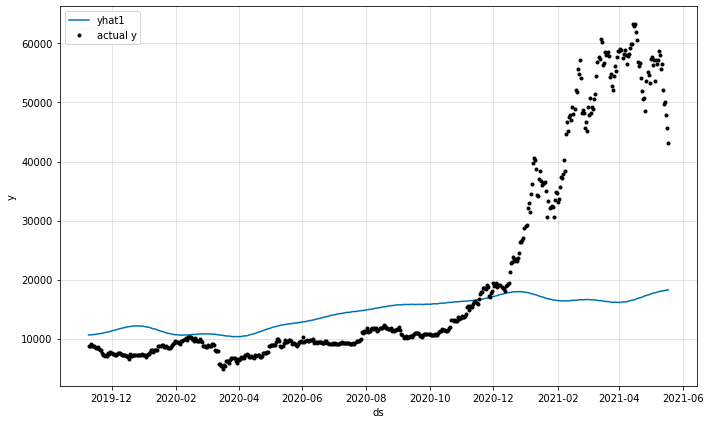

In [ ]:
### with spliting train and test   
m = NeuralProphet() 
df_train, df_test = m.split_df(bitcoin_prices, valid_p=0.2,freq='D')

# fiting 
metricss = m.fit(df_train, validation_df=df_test , freq='D')

# predict
forecast = m.predict(df_test)

# plot
fig_forecast = m.plot(forecast)

In [ ]:
forecast

,ds,y,yhat1,residual1,trend,season_yearly,season_weekly
0,2019-11-09,8794.358645,10632.035156,1837.676512,10043.400391,578.638611,9.996484
1,2019-11-10,8798.042055,10650.179688,1852.137633,10059.279297,578.674194,12.225864
2,2019-11-11,9081.186878,10674.430664,1593.243786,10075.155273,579.524597,19.750578
3,2019-11-12,8711.534339,10684.740234,1973.205895,10091.034180,581.315613,12.390323
4,2019-11-13,8760.892718,10672.467773,1911.575055,10106.911133,584.169495,-18.613146
...,...,...,...,...,...,...,...
552,2021-05-14,49764.132082,18115.833984,-31648.298097,18807.718750,-656.854858,-35.029488
553,2021-05-15,50032.693137,18192.609375,-31840.083762,18823.595703,-640.982666,9.996484
554,2021-05-16,47885.625255,18225.039062,-29660.586192,18839.466797,-626.653687,12.225864
555,2021-05-17,45604.615754,18261.367188,-27343.248566,18855.347656,-613.731506,19.750578


In [ ]:
import tensorflow as tf
def mean_absolute_scaled_error(y_true,y_pred):

  mae = tf.reduce_mean(tf.abs(y_pred - y_true))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return (mae/mae_naive_no_season)

def evaluate_preds(y_true,y_pred):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)
  
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) 
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
y_true = np.array(forecast["y"])
y_pred = np.array(forecast["yhat1"])

results_neural_prophet = evaluate_preds(y_true,y_pred)
results_neural_prophet

{'mae': 10565.123,
 'mape': 44.225746,
 'mase': 18.593218,
 'mse': 287402300.0,
 'rmse': 16952.943}

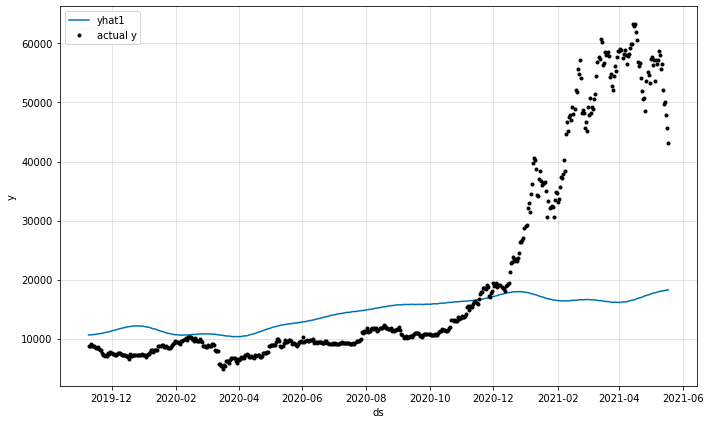

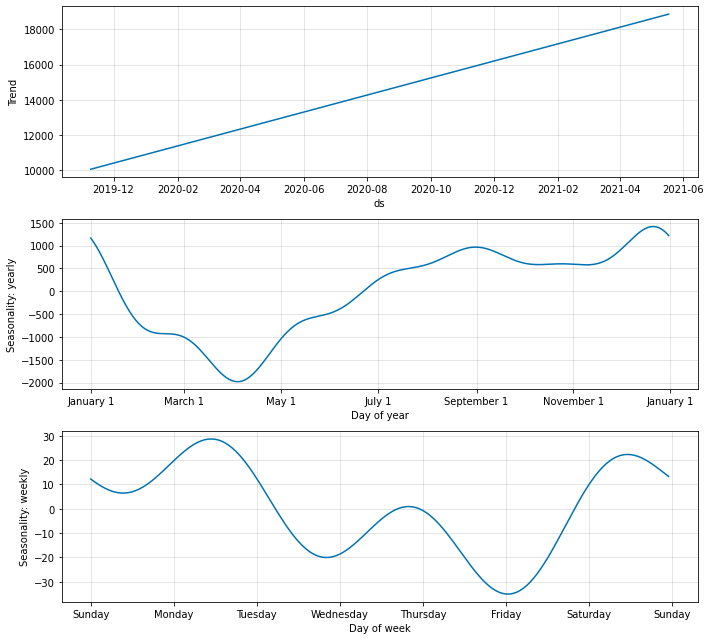

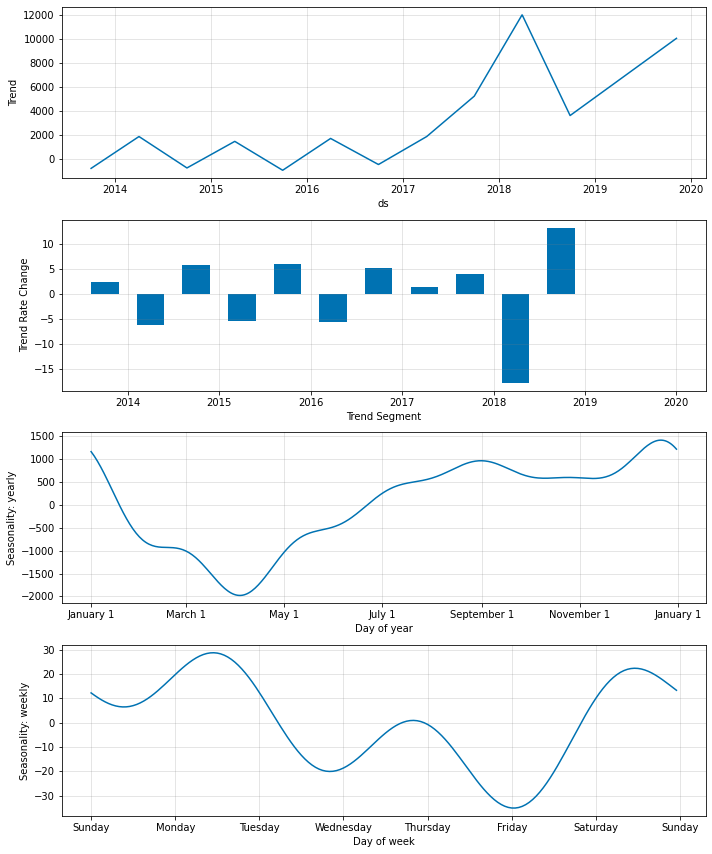

In [ ]:
# plot
fig_forecast = m.plot(forecast)
fig_components = m.plot_components(forecast)
fig_model = m.plot_parameters()

###Statistical Models

####*ARIMA Model*


**Key aspects of the model:**

AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.

I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.


**The parameters of the ARIMA model are defined as follows:**

p: The number of lag observations included in the model, also called the lag order.

d: The number of times that the raw observations are differenced, also called the degree of differencing.

q: The size of the moving average window, also called the order of moving average

In [ ]:
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# fit an ARIMA model and plot residual errors
import pandas as pd
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until

  This is separate from the ipykernel package so we can avoid doing imports until



In [ ]:
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",parse_dates=["Date"],index_col=["Date"])
bitcoin_prices = df[["Closing Price (USD)"]].rename(columns = {"Closing Price (USD)":"prices"})
bitcoin_prices.index = bitcoin_prices.index.to_period('M')
bitcoin_prices

,prices
Date,
2013-10,123.654990
2013-10,125.455000
2013-10,108.584830
2013-10,118.674660
2013-10,121.338660
...,...
2021-05,49764.132082
2021-05,50032.693137
2021-05,47885.625255


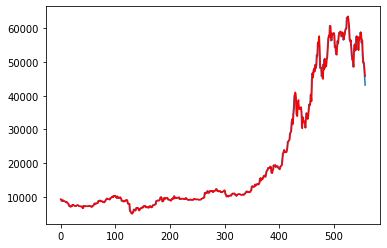

In [ ]:
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",parse_dates=["Date"],index_col=["Date"])
series = df[["Closing Price (USD)"]].rename(columns = {"Closing Price (USD)":"prices"})
#series.index = series.index.to_period('M')

# split into train and test sets
X = series.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	#print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
#rmse = sqrt(mean_squared_error(test, predictions))
#print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
import numpy as np

y_true = np.array(test)
y_pred = np.array(predictions)

ARIMA_results = evaluate_preds(y_true,y_pred)
ARIMA_results

{'mae': 570.6426,
 'mape': 2.5234728,
 'mase': 1.0046874,
 'mse': 1173822.1,
 'rmse': 570.6426}

##Comparing Results of our Model

In [ ]:
results = pd.DataFrame(
    {"naive_results":naive_results,
    "model1_results":model1_results,
    "model2_results":model2_results,
    "model3_results":model3_results,
    "model4_results":model4_results,
    "model5_results":model5_results,
    "model6_results":model6_results,
    "model_7_results":model_7_results,
    "ensemble_results":ensemble_results,
    "neural_prophet":results_neural_prophet,
    "ARIMA_results":ARIMA_results
     }
).T

results

,mae,mse,rmse,mape,mase
naive_results,567.980225,1.147547e+06,1071.236206,2.516525,0.999570
model1_results,565.393982,1.158886e+06,1076.515869,2.523508,0.993241
model2_results,578.392822,1.183378e+06,1087.831909,2.638266,1.011036
model3_results,1188.209595,5.068380e+06,1371.689941,5.425085,2.114352
model4_results,564.329529,1.156321e+06,1075.323608,2.524814,0.991371
model5_results,568.200806,1.166412e+06,1080.005615,2.537592,0.998171
model6_results,568.811951,1.164400e+06,1079.073853,2.553627,0.999245
model_7_results,573.786804,1.140931e+06,1068.143555,2.590601,1.007985
ensemble_results,565.847351,1.141936e+06,1068.613892,2.573646,0.994037
neural_prophet,10565.123047,2.874023e+08,16952.943359,44.225746,18.593218


The majority of our deep learning models perform on par or only slightly better than the naive model. 

☹

###Extra Resources

https://medium.com/coinmonks/bitcoin-arima-model-f22456bd1fa9

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

https://github.com/KinzCode/BTC-ARIMA-Model/blob/main/src/eda.py

https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/